In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')
%cd gdrive/My\ Drive/KKB-kaggle/bengaliai-cv19/notebooks

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/
/content/gdrive/My Drive/KKB-kaggle/bengaliai-cv19/notebooks


In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

In [0]:
## 前処理

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import recall_score
import cv2
# from tqdm.auto import tqdm
import copy
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, utils
from torch.autograd import Variable
import torch.optim as optim
import torchvision
import PIL
# from torchsummary import summary
import gc

dataset_dir = '../dataset'
# dataset_dir = '/kaggle/input/bengaliai-cv19'
train_df = pd.read_csv(dataset_dir + '/train.csv')
test_df = pd.read_csv(dataset_dir + '/test.csv')
class_map_df = pd.read_csv(dataset_dir + '/class_map.csv')
sample_sub_df = pd.read_csv(dataset_dir + '/sample_submission.csv')

HEIGHT = 137
WIDTH = 236

# 前処理を関数にまとめた
def resize(X, out_height=64, out_width=64):
    print('Resizing raw image... / 前処理実行中…')
    # resized = {} # 前処理された画像が格納されるリスト
    resized = np.zeros((len(X), out_height * out_width))

    for i in range(len(X)):
        image = X.iloc[[i]].values.reshape(HEIGHT, WIDTH)
        _, thresh = cv2.threshold(image, 30, 255, cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)
        contours, _ = cv2.findContours(thresh, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)[-2:]
        left = 1000
        right = -1
        top = 1000
        bottom = -1

        for cnt in contours:
            x,y,w,h = cv2.boundingRect(cnt)
            left = min(x, left)
            right = max(x+w, right)
            top = min(y, top)
            bottom = max(y+h, bottom)

        roi = image[top:bottom, left:right]
        resized_roi = cv2.resize(roi, (out_height, out_width),interpolation=cv2.INTER_AREA)
        resized[i] = resized_roi.reshape(-1)

    # print(len(resized))

    return resized


def try_gpu(e):
    if torch.cuda.is_available():
        return e.cuda()
    return e


In [0]:
## モデル定義

class model(nn.Module):
    def __init__(self):
        super(model, self).__init__()

        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv3 = nn.Conv2d(32, 32, 3, padding=1)
        self.conv4 = nn.Conv2d(32, 32, 3, padding=1)
        self.b1 = nn.BatchNorm2d(32, momentum=0.15)     
        self.pool = nn.MaxPool2d(2,2)
        self.conv5 = nn.Conv2d(32, 32, 5, padding=2)
        self.conv5_dropout = nn.Dropout(p=0.3)

        self.conv6 = nn.Conv2d(32, 64, 3, padding=1)
        self.conv7 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv8 = nn.Conv2d(64, 64, 3, padding=1)
        self.conv9 = nn.Conv2d(64, 64, 3, padding=1)
        self.b2 = nn.BatchNorm2d(64, momentum=0.15)
        # self.pool = nn.MaxPool2d(2,2) same as upper pool
        self.conv10 = nn.Conv2d(64, 64, 5, padding=2)
        self.b3 = nn.BatchNorm2d(64, momentum=0.15)
        self.conv10_dropout = nn.Dropout(p=0.3)

        self.conv11 = nn.Conv2d(64, 128, 3, padding=1)
        self.conv12 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv13 = nn.Conv2d(128, 128, 3, padding=1)
        self.conv14 = nn.Conv2d(128, 128, 3, padding=1)
        self.b4 = nn.BatchNorm2d(128, momentum=0.15)
        # self.pool = nn.MaxPool2d(2,2) same as upper pool
        self.conv15 = nn.Conv2d(128, 128, 5, padding=2)
        self.b5 = nn.BatchNorm2d(128, momentum=0.15)
        self.conv15_dropout = nn.Dropout(p=0.3)

        self.conv16 = nn.Conv2d(128, 256, 3, padding=1)
        self.conv17 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv18 = nn.Conv2d(256, 256, 3, padding=1)
        self.conv19 = nn.Conv2d(256, 256, 3, padding=1)
        self.b6 = nn.BatchNorm2d(256, momentum=0.15)
        # self.pool = nn.MaxPool2d(2,2) same as upper pool
        self.conv20 = nn.Conv2d(256, 256, 5, padding=2)
        self.b7 = nn.BatchNorm2d(256, momentum=0.15)
        self.conv20_dropout = nn.Dropout(p=0.3)

        self.dense1 = nn.Linear(256*4*4, 1024)
        self.dense1_dropout = nn.Dropout(p=0.3) # +relu
        self.dense2 = nn.Linear(1024, 512) # +relu

        self.head_root = nn.Linear(512, 168) # + softmax
        self.head_vowel = nn.Linear(512, 11) # + softmax
        self.head_consonant = nn.Linear(512, 7) # + softmax

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = self.pool(F.relu(self.b1(self.conv4(x))))
        x = F.relu(self.conv5(x))
        x = self.conv5_dropout(x)
        
        x = F.relu(self.conv6(x))
        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool(F.relu(self.b2(self.conv9(x))))
        x = F.relu(self.b3(self.conv10(x)))
        x = self.conv10_dropout(x)

        x = F.relu(self.conv11(x))
        x = F.relu(self.conv12(x))
        x = F.relu(self.conv13(x))
        x = self.pool(F.relu(self.b4(self.conv14(x))))
        x = F.relu(self.b5(self.conv15(x)))
        x = self.conv15_dropout(x)

        x = F.relu(self.conv16(x))
        x = F.relu(self.conv17(x))
        x = F.relu(self.conv18(x))
        x = self.pool(F.relu(self.b6(self.conv19(x))))
        x = F.relu(self.b7(self.conv20(x)))
        x = self.conv20_dropout(x)

        x = x.view(-1, 256*4*4)
        x = F.relu(self.dense1(x))
        x = F.relu(self.dense2(x))
        
        head_root = self.head_root(x)
        head_vowel = self.head_vowel(x)
        head_consonant = self.head_consonant(x)

        return head_root, head_vowel, head_consonant # not sure..

model = model()
model = try_gpu(model)

criterion1 = nn.CrossEntropyLoss() 
#criterion2 = nn.CrossEntropyLoss() 
#criterion3 = nn.CrossEntropyLoss() 
optimizer = optim.Adam(model.parameters())

In [0]:
## train関数、test関数

def train(model, epoch, train_loader):
    model.train()
    print(f'Epoch number {epoch}')
    for i, data in enumerate(train_loader, 0):
        inputs, root_l, vowel_l, consonant_l = data
        inputs, root_l, vowel_l, consonant_l = Variable(inputs), Variable(root_l), Variable(vowel_l), Variable(consonant_l)
        inputs, root_l, vowel_l, consonant_l = try_gpu(inputs), try_gpu(root_l), try_gpu(vowel_l), try_gpu(consonant_l)
        optimizer.zero_grad()
        root_o, vowel_o, consonant_o = model(inputs)
        loss1 = criterion1(root_o, root_l)
        loss2 = criterion1(vowel_o, vowel_l)
        loss3 = criterion1(consonant_o, consonant_l)
        (loss1+loss2+loss3).backward()
        optimizer.step()
        # if i % 500 == 0:
        #     print("epoch{} root {}/{}  loss: {}".format(epoch, i*len(inputs), len(train_loader)*len(inputs), loss1.data))
        #     print("epoch{} vowel {}/{}  loss: {}".format(epoch, i*len(inputs), len(train_loader)*len(inputs), loss2.data))
        #     print("epoch{} consonant {}/{}  loss: {}".format(epoch, i*len(inputs), len(train_loader)*len(inputs), loss3.data))

def test(model, test_loader):
    model.eval()

    size = len(test_loader.dataset)
    pred_r, pred_v, pred_c = np.zeros(size), np.zeros(size), np.zeros(size)
    true_r, true_v, true_c = np.zeros(size), np.zeros(size), np.zeros(size)
    index = 0
    
    for data in test_loader:
        inputs, root_l, vowel_l, consonant_l = data
        inputs, root_l, vowel_l, consonant_l = Variable(inputs), Variable(root_l), Variable(vowel_l), Variable(consonant_l)
        inputs, root_l, vowel_l, consonant_l = try_gpu(inputs), try_gpu(root_l), try_gpu(vowel_l), try_gpu(consonant_l)
        
        root_o, vowel_o, consonant_o = model(inputs) 
        root_pred, vowel_pred, consonant_pred = torch.max(root_o.data,1)[1], torch.max(vowel_o.data,1)[1], torch.max(consonant_o.data,1)[1]
        for i in range(inputs.size(0)):
            pred_r[index] = root_pred[i]
            pred_v[index] = vowel_pred[i]
            pred_c[index] = consonant_pred[i]
            true_r[index] = root_l[i]
            true_v[index] = vowel_l[i]
            true_c[index] = consonant_l[i]
            index += 1

    recall_r = recall_score(true_r, pred_r, average='macro')
    recall_v = recall_score(true_v, pred_v, average='macro')
    recall_c = recall_score(true_c, pred_c, average='macro')
    final_score = (2.*recall_r + recall_v + recall_c) / 4.

    print(f'Root Recall: {recall_r:.5f}')
    print(f'Vowel Recall: {recall_v:.5f}')
    print(f'Consonant Recall: {recall_c:.5f}')
    print(f'Score: {final_score:.5f}')
 


    # total_r, total_v, total_c = 0,0,0
    # correct_r, correct_v, correct_c = 0,0,0

    # for data in test_loader:
    #     inputs, root_l, vowel_l, consonant_l = data
    #     inputs, root_l, vowel_l, consonant_l = Variable(inputs), Variable(root_l), Variable(vowel_l), Variable(consonant_l)
    #     inputs, root_l, vowel_l, consonant_l = try_gpu(inputs), try_gpu(root_l), try_gpu(vowel_l), try_gpu(consonant_l)
        
    #     root_o, vowel_o, consonant_o = model(inputs)
    #     root_pred, vowel_pred, consonant_pred = torch.max(root_o.data,1)[1], torch.max(vowel_o.data,1)[1], torch.max(consonant_o.data,1)[1]
    #     total_r += root_l.size(0)
    #     correct_r += (root_pred == root_l).sum()
    #     total_v += vowel_l.size(0)
    #     correct_v += (vowel_pred == vowel_l).sum()
    #     total_c += consonant_l.size(0)
    #     correct_c += (consonant_pred == consonant_l).sum()

    # print("root Accuracy {}/{} {:.2f}%".format(correct_r, total_r, 100.0*correct_r/total_r))
    # print("vowel Accuracy {}/{} {:.2f}%".format(correct_v, total_v, 100.0*correct_v/total_v))
    # print("consonant Accuracy {}/{} {:.2f}%".format(correct_c, total_c, 100.0*correct_c/total_c))
 


In [0]:
## データセット準備

# Augmentation

transform_crop = transforms.Compose([
                                transforms.ToPILImage(),
                                transforms.RandomResizedCrop((64,64), scale=(0.80, 0.90)),
                                transforms.ToTensor()
])


rotate_left = transforms.RandomAffine((-20, -10), fillcolor=255, resample=PIL.Image.BILINEAR)
rotate_right = transforms.RandomAffine((10, 20), fillcolor=255, resample=PIL.Image.BILINEAR)
transform_rotate = transforms.Compose([
                                       transforms.ToPILImage(),
                                       transforms.RandomChoice([rotate_left, rotate_right]),
                                       transforms.ToTensor()
])


class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1.):
        self.std = std
        self.mean = mean
        
    def __call__(self, tensor):
        with_noise = tensor + torch.randn(tensor.size()) * self.std + self.mean
        return torch.max(torch.min(with_noise, torch.tensor(1.)), torch.tensor(0.))
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)

transform_noise = AddGaussianNoise(0., 0.01)


class IdentityTransform(object):
    def __call__(self, tensor):
        return tensor

transform_none = IdentityTransform()    # "何もしない" という transform

# PyTorch式のデータセットクラスを定義

class MyDataset(torch.utils.data.Dataset):

    def __init__(self, X, Y, transform=None):
        self.transform = transform
        self.X = X
        self.Y = Y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        out_data = self.X[idx].reshape(1,64,64)
        out_data = torch.tensor(out_data, dtype=torch.float)

        #root_label = torch.tensor(self.Y[0][idx], dtype=torch.long)
        #vowel_label = torch.tensor(self.Y[1][idx], dtype=torch.long)
        #cons_label = torch.tensor(self.Y[2][idx], dtype=torch.long)

        root_label = torch.tensor(np.argmax(self.Y[0][idx]), dtype=torch.long)
        vowel_label = torch.tensor(np.argmax(self.Y[1][idx]), dtype=torch.long)
        cons_label = torch.tensor(np.argmax(self.Y[2][idx]), dtype=torch.long)

        if self.transform:
            out_data = self.transform(out_data)
            # print("called transform")

        return out_data, root_label, vowel_label, cons_label


class TransformDataset(torch.utils.data.Dataset):

    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        out_data, root_label, vowel_label, cons_label = self.dataset[idx]

        if self.transform:
            out_data = self.transform(out_data)
            # print("called transform (2)")

        return out_data, root_label, vowel_label, cons_label


In [18]:
## 訓練ループ / Training Loop

###############
# True なら Cross Validation を実施する
# Kaggle に提出するときは False にしてください
do_validation = True

# True なら submission.csv を生成する
create_submission = False

val_perc = 0.2  # validation set の割合（クロスバリデーション）
epochs = 2

###############

for parq_i in range(4):
    print('=============================')
    print(f'Parquet {parq_i} の訓練を開始')

    train_df_with_img = pd.merge(pd.read_parquet(dataset_dir + f'/train_image_data_{parq_i}.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)

    X_train = train_df_with_img.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'])

    # X_train_resized = pd.DataFrame(resize(X_train)).T / 255.0   # 値を0~1におさめる
    # X_train_resized = X_train_resized.values
    X_train_resized = resize(X_train) / 255.0

    # メモリ節約
    del X_train

    # PyTorchのデータセットクラスを作る前に、ラベルの情報も整備
    # 1-of-K符号化とか、One Hot Encodingとか呼ばれる方法でラベルをつくる
    # 注：　PyTorchでは、ラベルはOne Hotじゃなくて良いことが判明したので、結局 MyDataset で元のラベルに戻している

    Y_train_root = pd.get_dummies(train_df_with_img['grapheme_root']).values
    Y_train_vowel = pd.get_dummies(train_df_with_img['vowel_diacritic']).values
    Y_train_cons = pd.get_dummies(train_df_with_img['consonant_diacritic']).values

    Y_train = [Y_train_root, Y_train_vowel, Y_train_cons]

    trainval_dataset = MyDataset(X_train_resized, Y_train)

    del train_df_with_img
    del X_train_resized
    gc.collect()

    if do_validation:
        n_samples = len(trainval_dataset)
        train_size = int(len(trainval_dataset)*(1.0 - val_perc))
        val_size = n_samples - train_size
        print(f'train size: {train_size}, validation size: {val_size}')

        subset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

        train_dataset = TransformDataset(subset, transform=transforms.RandomChoice(
            [transform_none, transform_crop, transform_rotate, transform_noise]
        ))

        del trainval_dataset
        del subset
        gc.collect()

        train_loader = DataLoader(dataset=train_dataset, batch_size=32, shuffle=True, num_workers=4)
        val_loader = DataLoader(dataset=val_dataset, batch_size=32, num_workers=0)

        for i in range(1,epochs+1):
            train(model, i, train_loader)
            test(model, val_loader)

        # メモリ節約
        del train_dataset
        del val_dataset
        del train_loader
        del val_loader
        gc.collect()

    else:
        n_samples = len(trainval_dataset)
        print(f'train size: {n_samples}')

        trainval_dataset.transform = transforms.RandomChoice(
            [transform_none, transform_crop, transform_rotate, transform_noise]
        )

        train_loader = DataLoader(dataset=trainval_dataset, batch_size=32, shuffle=True, num_workers=4)

        for i in range(1,epochs+1):
            train(model, i, train_loader)

        # メモリ節約
        del trainval_dataset
        del train_loader
        gc.collect()


Parquet 0 の訓練を開始
Resizing raw image... / 前処理実行中…
train size: 40168, validation size: 10042
Epoch number 1
Root Recall: 0.02931
Vowel Recall: 0.56403
Consonant Recall: 0.29424
Score: 0.22922
Epoch number 2
Root Recall: 0.08564
Vowel Recall: 0.64515
Consonant Recall: 0.39020
Score: 0.30166
Parquet 1 の訓練を開始
Resizing raw image... / 前処理実行中…
train size: 40168, validation size: 10042
Epoch number 1
Root Recall: 0.19959
Vowel Recall: 0.76769
Consonant Recall: 0.64734
Score: 0.45355
Epoch number 2
Root Recall: 0.32425
Vowel Recall: 0.78899
Consonant Recall: 0.72331
Score: 0.54020
Parquet 2 の訓練を開始
Resizing raw image... / 前処理実行中…
train size: 40168, validation size: 10042
Epoch number 1
Root Recall: 0.43206
Vowel Recall: 0.83838
Consonant Recall: 0.76092
Score: 0.61585
Epoch number 2
Root Recall: 0.49985
Vowel Recall: 0.88526
Consonant Recall: 0.80649
Score: 0.67286
Parquet 3 の訓練を開始
Resizing raw image... / 前処理実行中…
train size: 40168, validation size: 10042
Epoch number 1
Root Recall: 0.61690
Vowel 

In [19]:
## 提出ファイルの作成

target=[]
row_id=[] # row_id place holder

for parq_i in range(4):
    df_test_img = pd.read_parquet(dataset_dir + f'/test_image_data_{parq_i}.parquet')
    # df_test_img = pd.read_parquet(dataset_dir + f'/train_image_data_{parq_i}.parquet') # Error Check!
    df_test_img.set_index('image_id', inplace=True)

    # X_test_resized = resize(df_test_img)
    # X_test_resized = pd.DataFrame(X_test_resized).T / 255.0   # 値を0~1におさめる
    # X_test_resized = X_test_resized.values.reshape(-1, 1, 64, 64)

    X_test_resized = resize(df_test_img).reshape(-1, 1, 64, 64) / 255.0

    test_inputs = torch.tensor(X_test_resized, dtype=torch.float)
    test_inputs = Variable(test_inputs)
    test_inputs = try_gpu(test_inputs)

    del X_test_resized
    gc.collect()

    for k, id in enumerate(df_test_img.index.values):
        data = test_inputs[k].reshape(1,1,64,64)
        root_o, vowel_o, consonant_o = model(data)
        root_pred, vowel_pred, consonant_pred = torch.max(root_o.data,1)[1], torch.max(vowel_o.data,1)[1], torch.max(consonant_o.data,1)[1]
        if torch.cuda.is_available():
            root_pred, vowel_pred, consonant_pred = root_pred.to(torch.device("cpu")), vowel_pred.to(torch.device("cpu")), consonant_pred.to(torch.device("cpu"))

        root_pred, vowel_pred, consonant_pred = root_pred.item(), vowel_pred.item(), consonant_pred.item()
        
        row_id.append(id+'_consonant_diacritic')
        target.append(consonant_pred)
        row_id.append(id+'_grapheme_root')
        target.append(root_pred)
        row_id.append(id+'_vowel_diacritic')
        target.append(vowel_pred)
    
    del df_test_img
    gc.collect()

df_sample = pd.DataFrame(
    {
        'row_id': row_id,
        'target':target
    },
    columns = ['row_id','target'] 
)

if create_submission:
    df_sample.to_csv('submission.csv',index=False)

df_sample.head(36)

Resizing raw image... / 前処理実行中…
Resizing raw image... / 前処理実行中…
Resizing raw image... / 前処理実行中…
Resizing raw image... / 前処理実行中…


,row_id,target
0,Test_0_consonant_diacritic,0
1,Test_0_grapheme_root,3
2,Test_0_vowel_diacritic,1
3,Test_1_consonant_diacritic,0
4,Test_1_grapheme_root,93
5,Test_1_vowel_diacritic,2
6,Test_2_consonant_diacritic,0
7,Test_2_grapheme_root,19
8,Test_2_vowel_diacritic,0
9,Test_3_consonant_diacritic,0


In [0]:
### 以下テスト用のコード！ ###

In [0]:
# train_df_with_img = pd.merge(pd.read_parquet(dataset_dir + f'/train_image_data_{0}.parquet'), train_df, on='image_id').drop(['image_id'], axis=1)
# X_train = train_df_with_img.drop(columns=['grapheme_root', 'vowel_diacritic', 'consonant_diacritic', 'grapheme'])
# X_train_resized = resize(X_train) / 255.0

# val_perc = 0.2

# # メモリ節約
# del X_train

# Y_train_root = pd.get_dummies(train_df_with_img['grapheme_root']).values
# Y_train_vowel = pd.get_dummies(train_df_with_img['vowel_diacritic']).values
# Y_train_cons = pd.get_dummies(train_df_with_img['consonant_diacritic']).values

# Y_train = [Y_train_root, Y_train_vowel, Y_train_cons]

# trainval_dataset = MyDataset(X_train_resized, Y_train)

# # n_samples = len(trainval_dataset)
# # train_size = int(len(trainval_dataset)*(1.0 - val_perc))
# # val_size = n_samples - train_size
# # print(f'train size: {train_size}, validation size: {val_size}')

# # subset, val_dataset = torch.utils.data.random_split(trainval_dataset, [train_size, val_size])

# # train_dataset = TransformDataset(subset, transform=transforms.RandomChoice(
# #     [transform_none, transform_crop, transform_rotate, transform_noise]
# # ))

# trainval_dataset.transform = transforms.RandomChoice(
#             [transform_none, transform_crop, transform_rotate, transform_noise]
# )

called transform
called transform
called transform
called transform
called transform
called transform
called transform
called transform
called transform
called transform
called transform
called transform


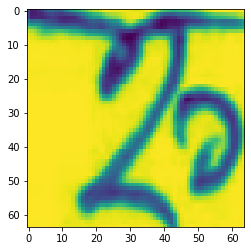

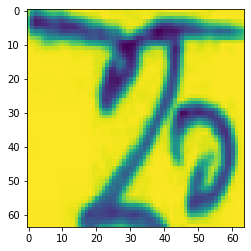

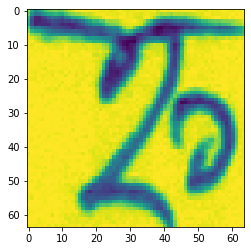

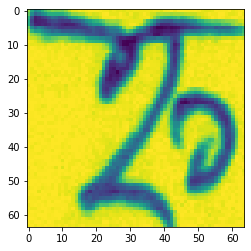

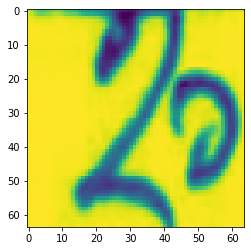

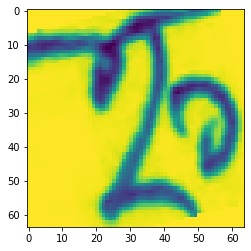

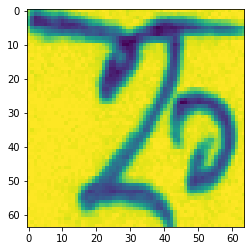

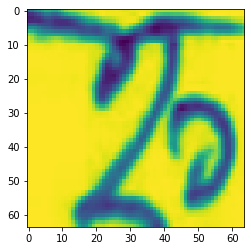

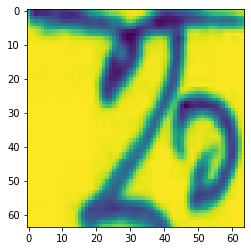

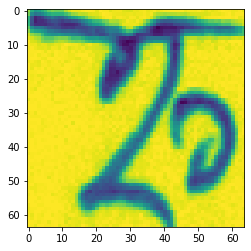

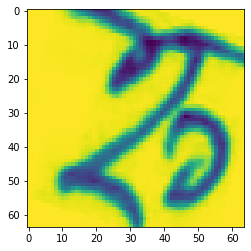

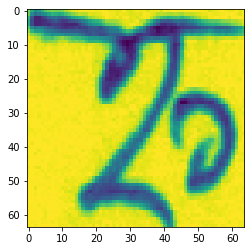

In [11]:
# for i in range(12):
#     data, _, _, _ = trainval_dataset[29]
#     to_PIL = transforms.ToPILImage()
#     data = to_PIL(data)

#     plt.figure()
#     plt.imshow(data)